# Heurística BMTSP
Este notebook implementa una heurística constructiva con mejora local para el Bounded Multiple Traveling Salesman Problem (BMTSP). Se usan los archivos CSV en `datos/` como conjunto de ciudades.

In [1]:
import csv
import math
import random
from dataclasses import dataclass

In [2]:
@dataclass
class City:
    idx: int
    x: float
    y: float

    def distance_to(self, other: "City") -> float:
        return math.hypot(self.x - other.x, self.y - other.y)

In [3]:
def load_cities(path):
    cities = []
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            idx = int(row.get('id', row.get('idx')))
            cities.append(City(idx, float(row['x']), float(row['y'])))
    cities.sort(key=lambda c: c.idx)
    return cities

In [4]:
def nearest_neighbor_route(cities, start):
    route = [start]
    remaining = cities[:]
    current = start
    while remaining:
        next_city = min(remaining, key=lambda c: current.distance_to(c))
        route.append(next_city)
        remaining.remove(next_city)
        current = next_city
    route.append(start)
    return route

In [5]:
def route_length(route):
    return sum(route[i].distance_to(route[i+1]) for i in range(len(route)-1))

In [6]:
def two_opt(route):
    improved = True
    best = route
    while improved:
        improved = False
        for i in range(1, len(best) - 2):
            for j in range(i + 1, len(best) - 1):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if route_length(new_route) < route_length(best):
                    best = new_route
                    improved = True
        route = best
    return best

In [7]:
def assign_cities(cities, k, max_ciudades):
    depot = cities[0]
    others = cities[1:]
    random.shuffle(others)
    ass = [[] for _ in range(k)]
    idx = 0
    for city in others:
        ass[idx % k].append(city)
        idx += 1
    for i in range(k):
        ass[i] = ass[i][:max_ciudades]
    return ass

In [8]:
def heuristic_bmtsp(cities, k, max_ciudades):
    depot = cities[0]
    assignments = assign_cities(cities, k, max_ciudades)
    routes = []
    total_cost = 0.0
    for assigned in assignments:
        if not assigned:
            routes.append([depot, depot])
            continue
        route = nearest_neighbor_route(assigned, depot)
        route = two_opt(route)
        routes.append(route)
        total_cost += route_length(route)
    return routes, total_cost

In [9]:
# Ejemplo de ejecución
csv_path = 'datos/ciudades_pequeno.csv'
k = 2
max_ciudades = 5

cities = load_cities(csv_path)
routes, cost = heuristic_bmtsp(cities, k, max_ciudades)
print(f'Costo total: {cost:.2f}')
for i, route in enumerate(routes, 1):
    print(f'Vendedor {i}:', ' -> '.join(str(c.idx) for c in route))

Costo total: 276.35
Vendedor 1: 0 -> 8 -> 9 -> 1 -> 5 -> 7 -> 0
Vendedor 2: 0 -> 2 -> 3 -> 4 -> 6 -> 0


In [10]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [11]:
def plot_routes(routes):
    colors=[f'C{i}' for i in range(len(routes))]
    fig, ax = plt.subplots()
    for idx,(color,route) in enumerate(zip(colors, routes),1):
        xs=[c.x for c in route]
        ys=[c.y for c in route]
        ax.plot(xs, ys, marker='o', color=color, label=f'Vendedor {idx}')
    ax.set_title('Rutas generadas por la heurística')
    ax.legend()
    return fig

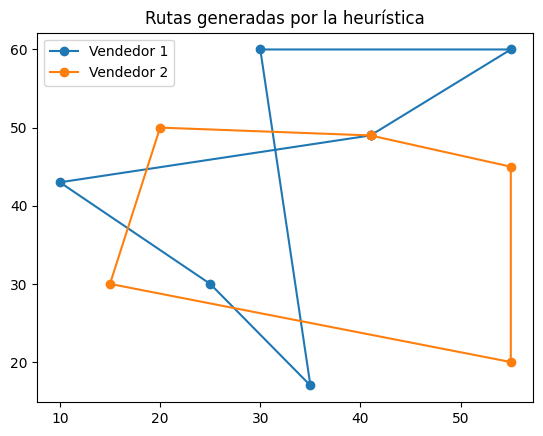

In [12]:
fig = plot_routes(routes)
plt.show()
fig.savefig('rutas.png')
with PdfPages('informe.pdf') as pdf:
    pdf.savefig(fig)
    plt.close(fig)
    fig2, ax2 = plt.subplots()
    ax2.axis('off')
    filas=[[i+1, len(r)-1, f'{route_length(r):.2f}'] for i,r in enumerate(routes)]
    ax2.table(cellText=filas, colLabels=['Vendedor','# Ciudades','Distancia'], loc='center')
    ax2.set_title(f'Costo total: {cost:.2f}')
    pdf.savefig(fig2)
    plt.close(fig2)
